In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, or_

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model (With Inspect Library Function)

# reflect the tables

inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
# reflect an existing database into a new model (With AutoMap Library Function)

# reflect the tables

Base = automap_base()
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

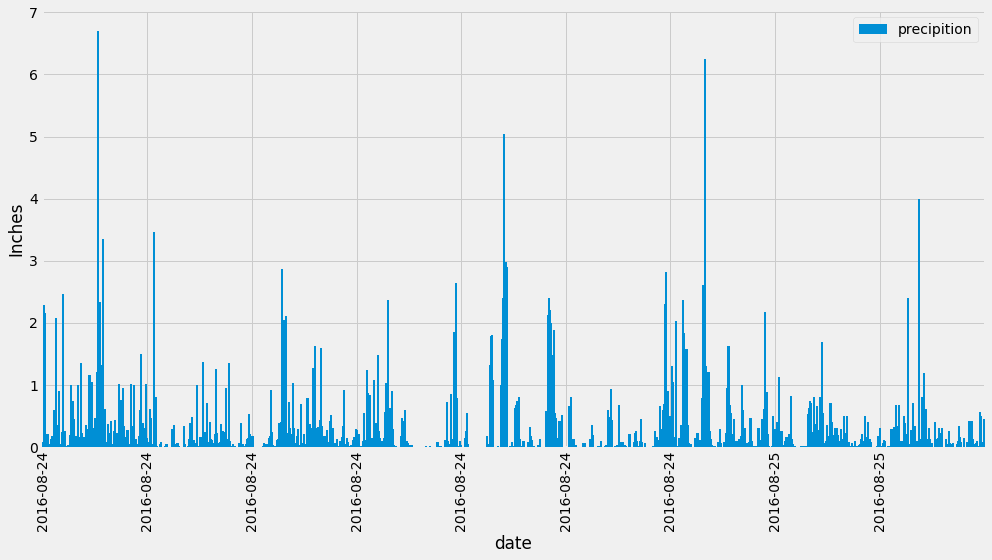

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
#first_date = session.query(Measurement.date).order_by(Measurement.date).first()
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

fmt = "('%Y-%m-%d',)"
latest_date_sql = dt.datetime.strptime(str(latest_date),fmt)

query_date = latest_date_sql - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date,
       Measurement.prcp]
    
data = session.query(*sel).filter(func.strftime("%Y-%m-%d", Measurement.date) >= query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column 
data_df = pd.DataFrame(data, columns=['date', 'precipition'])
data_df.set_index('date', inplace = True)

# Sort the dataframe by date
data_df = data_df.sort_values('date',ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data

ax = data_df.plot.bar(width=5.0,align='center',figsize=(14,8), zorder=3)
ax.set_ylabel("Inches")
ax.grid(zorder=0)
plt.locator_params(axis='x', nbins=9)
plt.tight_layout()
plt.show()



In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data

print("The Summary Statistics of the Precipitation Data Below:")

data_df.describe()

The Summary Statistics of the Precipitation Data Below:


,precipition
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?

station_cnt = session.query(Station.id).count()
print("The number of Stations in the Stations Dataset>>>", station_cnt)
print("")

station_cnt_mea = session.query(Measurement.station).group_by(Measurement.station).count()
print("The number of Stations in the Measurement Dataset>>>", station_cnt_mea)

The number of Stations in the Stations Dataset>>> 9

The number of Stations in the Measurement Dataset>>> 9


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station_cnt_max = session.query(Measurement.station, func.count(Measurement.station)).\
                  group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_cnt_max

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

station_max_temp = session.query(Measurement.station,func.max(Measurement.tobs)).\
                    filter(Measurement.station == 'USC00519281').all()
                
station_min_temp = session.query(Measurement.station,func.min(Measurement.tobs)).\
                    filter(Measurement.station == 'USC00519281').all()

station_avg_temp = session.query(Measurement.station,func.avg(Measurement.tobs)).\
                    filter(Measurement.station == 'USC00519281').all()
                
print("The Lowest temperature of the most active station is>>>", station_min_temp)
print("The Highest temperature of the most active station is>>>", station_max_temp)
print("The Average temperature of the most active station is>>>", station_avg_temp)

The Lowest temperature of the most active station is>>> [('USC00519281', 54.0)]
The Highest temperature of the most active station is>>> [('USC00519281', 85.0)]
The Average temperature of the most active station is>>> [('USC00519281', 71.66378066378067)]


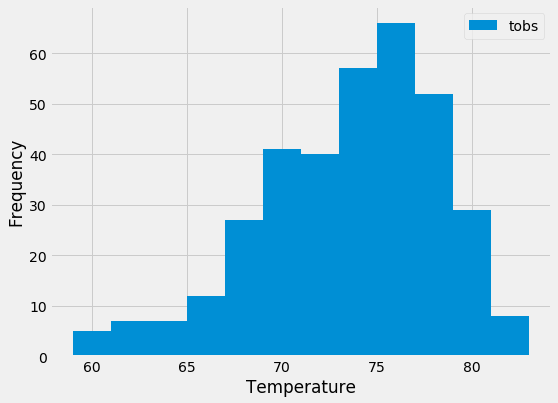

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

data_temp = session.query(Measurement.tobs).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= query_date).\
    filter(Measurement.station == 'USC00519281').all()

temperature_data = list(np.ravel(data_temp))

# Create the histogram chart.
plt.figure(figsize = (8,6))
plt.hist(temperature_data, bins=12)

# decorate the histogram chart for easier reading.
plt.legend(['tobs'], loc='upper right')
plt.ylabel('Frequency')
plt.xlabel('Temperature')

# Display the bar chart.
#plt.tight_layout()
plt.show()


## Bonus Challenge Assignment -- Temperature Analysis I
Un-Paired T-Test used because the number of samples (number of averages) are different.

In [17]:
# Import ttest from spicy stats
from scipy.stats import ttest_ind


# Perform a query to retrieve the data and recorded temperatures.
fmt = "('%Y-%m-%d',)"

sel = [Measurement.date,
       Measurement.station,
       Measurement.tobs]

# For June records.
# Save the query results as a Pandas DataFrame, set the date to Phyton Date Field, Extract the year for filtering.
# Calculate the mean for each year.

data = session.query(*sel).\
    filter(func.strftime("%m", Measurement.date) == "06").all()

data_temp_june = pd.DataFrame(data, columns=['date', 'station','tobs'])
data_temp_june['date'] = pd.to_datetime(data_temp_june['date'], format='%Y-%m-%d')
data_temp_june['year'] = pd.DatetimeIndex(data_temp_june['date']).year
data_june_avg = data_temp_june.groupby(['year']).mean()['tobs']

# For December records.
# Save the query results as a Pandas DataFrame, set the date to Phyton Date Field, Extract the year for filtering.
# Calculate the mean for each year.

data = session.query(*sel).\
    filter(func.strftime("%m", Measurement.date) == "12").all()
 
data_temp_dec = pd.DataFrame(data, columns=['date', 'station','tobs'])
data_temp_dec['date'] = pd.to_datetime(data_temp_dec['date'], format='%Y-%m-%d')
data_temp_dec['year'] = pd.DatetimeIndex(data_temp_dec['date']).year
data_dec_avg = data_temp_dec.groupby(['year']).mean()['tobs']

# Perform a test using Spicy Stats. Since the number of samples are not equal, we use the indendent (unpaired) test
# for these results of the data.

ttest_results = ttest_ind(data_june_avg, data_dec_avg)

print(ttest_results)
print(f"p-value is less than 0.05--> {ttest_results[1]}")
print("")
print("*** p-value is less than 0.05 ***")
print("The null hypothesis is false--> That there is a statistical difference between June and Dec Temps for HI.")
print("Which means that the hypothesis is true--> There is no statistical difference between June and Dec Temps for HI.")

Ttest_indResult(statistic=6.97605237788662, pvalue=9.681543069110451e-06)
p-value is less than 0.05--> 9.681543069110451e-06

*** p-value is less than 0.05 ***
The null hypothesis is false--> That there is a statistical difference between June and Dec Temps for HI.
Which means that the hypothesis is true--> There is no statistical difference between June and Dec Temps for HI.


## Bonus Challenge Assignment Part II

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

data = calc_temps('2017-07-20', '2017-08-02')
data = list(np.ravel(data))
yerr = data[2] - data[0]


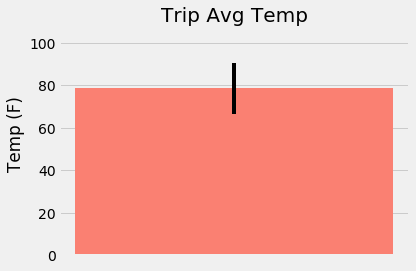

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

xval = ['']

plt.bar(xval, data[1], yerr=yerr, width= 0.5, align='center', color='salmon')
plt.xticks([])
plt.locator_params(axis='x', nbins=1)
plt.text(0, 110,'Trip Avg Temp', fontsize=20, horizontalalignment='center')
plt.ylabel("Temp (F)")
plt.ylim([0,115])
plt.tight_layout()
plt.show()

In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date = '2017-07-20'
end_date = '2017-08-02'

session.query(func.sum(Measurement.prcp),Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
    group_by(Station.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()


[(8.29,
  'USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 (1.8500000000000003,
  'USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 (1.6600000000000001,
  'USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 (1.1099999999999999,
  'USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6),
 (0.38,
  'USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 (0.13, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (0.01, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]

In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

normals = []

# Set the start and end date of the trip

start_date = dt.date(2017, 7,20)
end_date = dt.date(2017, 8, 2)
date_start = start_date
day_inc = dt.timedelta(days=1)

# Use the start and end date to create a range of dates
day_cnt = end_date - start_date
day_num = day_cnt.days

# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each dates

for dte in range(day_num):
    
    if date_start.month < 10:
        if date_start.day < 10:
            dte_str = f"0{date_start.month}-0{date_start.day}"
        else:
            dte_str = f"0{date_start.month}-{date_start.day}"
    else:
        if date_start.day < 10:
            dte_str = f"{date_start.month}-0{date_start.day}"
        else: 
            dte_str = f"{date_start.month}-{date_start.day}"
        
        
    #print (dte_str)
    
    normals.append(daily_normals(dte_str))
    date_start = date_start + day_inc
    
date_start = start_date

#normals

In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

trip_dates = []
trip_min = []
trip_avg = []
trip_max = []

date_start = start_date
day_inc = dt.timedelta(days=1)

# Use the start and end date to create a range of dates
day_cnt = end_date - start_date
day_num = day_cnt.days

for dte in range(day_num):
    
 #   print(f"{dte} data--> {normals[dte]}")
    just_data = list(np.ravel(normals[dte]))

    trip_min.append(just_data[0])
    trip_avg.append(just_data[1])
    trip_max.append(just_data[2])
    trip_dates.append(date_start)
    
    date_start = date_start + day_inc

trip_data_df = pd.DataFrame({'date':trip_dates,'tmin':trip_min,
                            'tavg':trip_avg, 'tmax':trip_max})
trip_data_df.set_index('date', inplace = True)

#trip_data_df

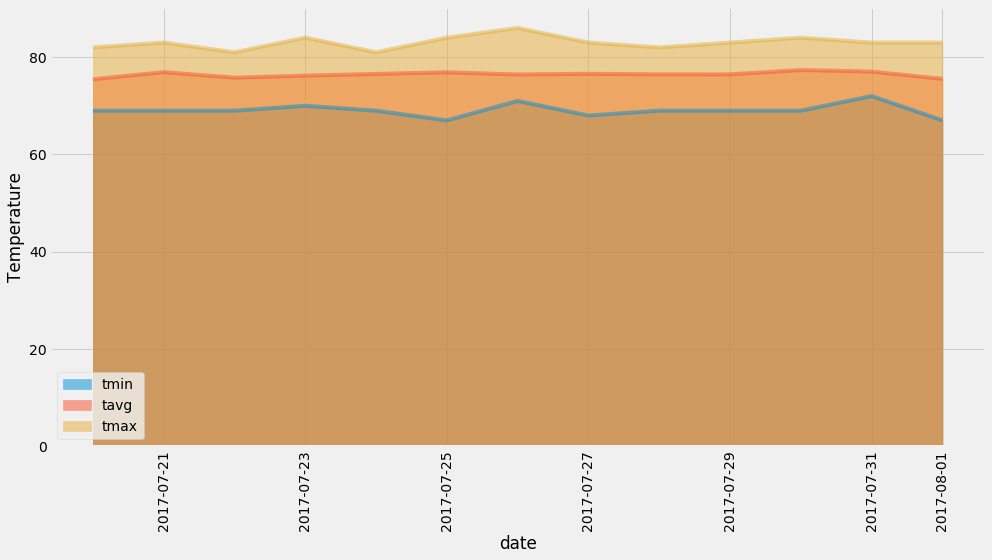

In [25]:
# Plot the daily normals as an area plot with `stacked=False`
ax = trip_data_df.plot.area(stacked=False, figsize = (14,8))
ax.set_ylabel("Temperature")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
